In [30]:
import sys
sys.path.append('/Volumes/SANDISK128/Documents/Thesis/Python/')
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np 
import pandas as pd
import datetime
from datetime import date
import calendar
import math

import TPU_savefig as PF
import calc_date as cd
import autolabel_bar as ab
import save_fig as SF
import get_Haukeli_obs_data as obsDat
import createFolder as cF


%matplotlib inline 

In [31]:
savefig = 0
txtdir = '../../eklima/'
txt_filename = 'Observations-hour_minutes.txt'
figdir = '../../Observations_results/Haukeli_weathermast/'
cF.createFolder(figdir)
form = 'png'


In [32]:
### define colors for colorbar
champ = 255
blue = np.array([1,74,159])/champ           # for the date


In [33]:
Haukeli = pd.read_csv('%s/%s' %(txtdir, txt_filename),\
                    sep = ';',header=19, skipfooter = 11, engine= 'python')

In [34]:
DateHour = Haukeli['Date-Hour(UTC)']

RR_1 = Haukeli['RR_1'].astype(float)           # Precipitation (1 hour); [mm]
TA = Haukeli['TA'].astype(float)               # Air temperature; [deg C] 

FF = Haukeli['FF'].astype(float)         # Wind speed (10 meters above ground); [m/s]
DD = Haukeli['DD'].astype(float)         # Wind direction (FF); [degrees]

In [35]:
idxFF = np.where(FF[:] == -9999)
idxDD = np.where(DD[:] == -9999)

FF[idxFF[0][:]] = np.nan
DD[idxDD[0][:]] = np.nan

### calculate the U, V wind component for barb plot
# http://colaweb.gmu.edu/dev/clim301/lectures/wind/wind-uv.html

# first calculate the mathematical wind direction in deg
md_deg = 270 - DD
for k in range(0,md_deg.shape[0]):
    if md_deg[k] <0 :
        md_deg[k] = md_deg[k] +360
md_rad = math.pi/180. * md_deg
uwind = FF*np.cos(md_rad)
vwind = FF*np.sin(md_rad)

In [36]:
idxT = np.where(TA[:] == -9999)
TA[idxT[0][:]] = np.nan

In [37]:
precip, dt_precip, hour_precip, day_precip, month_precip, year_precip = obsDat.valid_values(RR_1, DateHour)
temp, dt_temp, hour_temp, day_temp, month_temp, year_temp = obsDat.valid_values(TA, DateHour)
U_wind, V_wind, dt_wind, hour_wind, day_wind, month_wind, year_wind = obsDat.valid_values_wind(uwind, vwind, DateHour)
FF_31, DD_31, dt_FF, hour_FF, day_FF, month_FF, year_FF = obsDat.valid_values_wind(FF, DD, DateHour)


In [38]:
prec_sum = []
for k in range(0,31):
    if len(precip[k][:]) == 0:
        prec_sum.append(np.nan)
    else:
        prec_sum.append(np.nansum(precip[k][:]))
        

In [39]:
d_prec_sum = np.arange(0,np.asarray(prec_sum).shape[0])
d_prec_sum = d_prec_sum[~np.isnan(prec_sum)]

In [40]:
print('total precipiataion [mm] during %s. - %s.%s:' %(day_precip[20][0], day_precip[26][0], year_precip[0][0]),
                                                       np.sum(prec_sum[20:27]))

total precipiataion [mm] during 21. - 27.2016: 136.4


In [41]:
prec_sum = np.asarray(prec_sum)[~np.isnan(prec_sum)]

In [42]:
tot_prec = np.nansum(prec_sum)
print('total precipitation [mm] in %s.%s:' %(month_precip[0][0], year_precip[0][0]), tot_prec)

total precipitation [mm] in 12.2016: 239.9


In [43]:
U = []
V = []
for k in range(0,31):
    if len(FF_31[:][k]) == 0 or (FF_31[:][k]).shape[0] < 24:
        U.append(np.nan)
        continue
    
    idxFF = np.argmax(FF_31[:][k])
    U.append(U_wind[k][idxFF])
    V.append(V_wind[k][idxFF])
    print('maximum wind speed on %s.%s.%s' %(day_FF[k][idxFF], month_FF[k][idxFF], year_FF[k][idxFF]),FF_31[k][idxFF])

maximum wind speed on 1.12.2016 15.3
maximum wind speed on 7.12.2016 13.7
maximum wind speed on 8.12.2016 17.8
maximum wind speed on 9.12.2016 12.4
maximum wind speed on 10.12.2016 8.7
maximum wind speed on 11.12.2016 9.9
maximum wind speed on 12.12.2016 5.7
maximum wind speed on 13.12.2016 10.0
maximum wind speed on 14.12.2016 3.3
maximum wind speed on 15.12.2016 2.3
maximum wind speed on 16.12.2016 1.6
maximum wind speed on 17.12.2016 12.3
maximum wind speed on 18.12.2016 9.1
maximum wind speed on 19.12.2016 7.8
maximum wind speed on 20.12.2016 8.2
maximum wind speed on 21.12.2016 12.8
maximum wind speed on 22.12.2016 12.3
maximum wind speed on 23.12.2016 11.9
maximum wind speed on 24.12.2016 13.8
maximum wind speed on 25.12.2016 13.8
maximum wind speed on 26.12.2016 19.2
maximum wind speed on 27.12.2016 22.3
maximum wind speed on 28.12.2016 9.3
maximum wind speed on 29.12.2016 8.6
maximum wind speed on 30.12.2016 19.0
maximum wind speed on 31.12.2016 16.9


In [44]:
print('maximum wind speed during %s. - %s.%s:' %(day_precip[20][0], day_precip[26][0], year_precip[0][0]), np.asarray(FF_31[:][20:27]).max())

maximum wind speed during 21. - 27.2016: 22.3


In [45]:
Tmax = []
Tmin = []
Tmean = []
for k in range(0,31):
    Tmean.append(np.nanmean(temp[:][k]))
    if len(temp[:][k]) == 0:
        continue
    Tmax.append(np.nanmax(temp[:][k]))
    Tmin.append(np.nanmin(temp[:][k]))

Tmean = np.asarray(Tmean)



/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [46]:
print('mean temperature [°C] in %s.%s:' %(month_temp[0][0], year_temp[0][0]), np.nanmean(Tmean))

mean temperature [°C] in 12.2016: -1.11314484127


In [47]:
Tmean_6h = []
c = []
for k in range(0,31):
    for i in range(0,4):
        Tmean_6h.append(np.nanmean(np.asarray(temp)[k][i*6:(i+1)*6]))
    
Tmean_6h = np.asarray(Tmean_6h)      

/Volumes/SANDISK128/Applications/anaconda/envs/py36ECMWF/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


In [48]:
calday, calmon = cd.get_dayname(year_precip[1][0], month_precip[1][0], day_precip[1][0])
fig_name = 'T_P_U_%s%s.png' %(year_precip[1][0], month_precip[1][0])

In [49]:
prec_tick = np.arange(0,round(np.nanmax(prec_sum))+5,5)

In [50]:
T = np.arange(round(np.nanmin(np.asarray(Tmin))-1),round(np.nanmax(np.asarray(Tmax))+1),5)

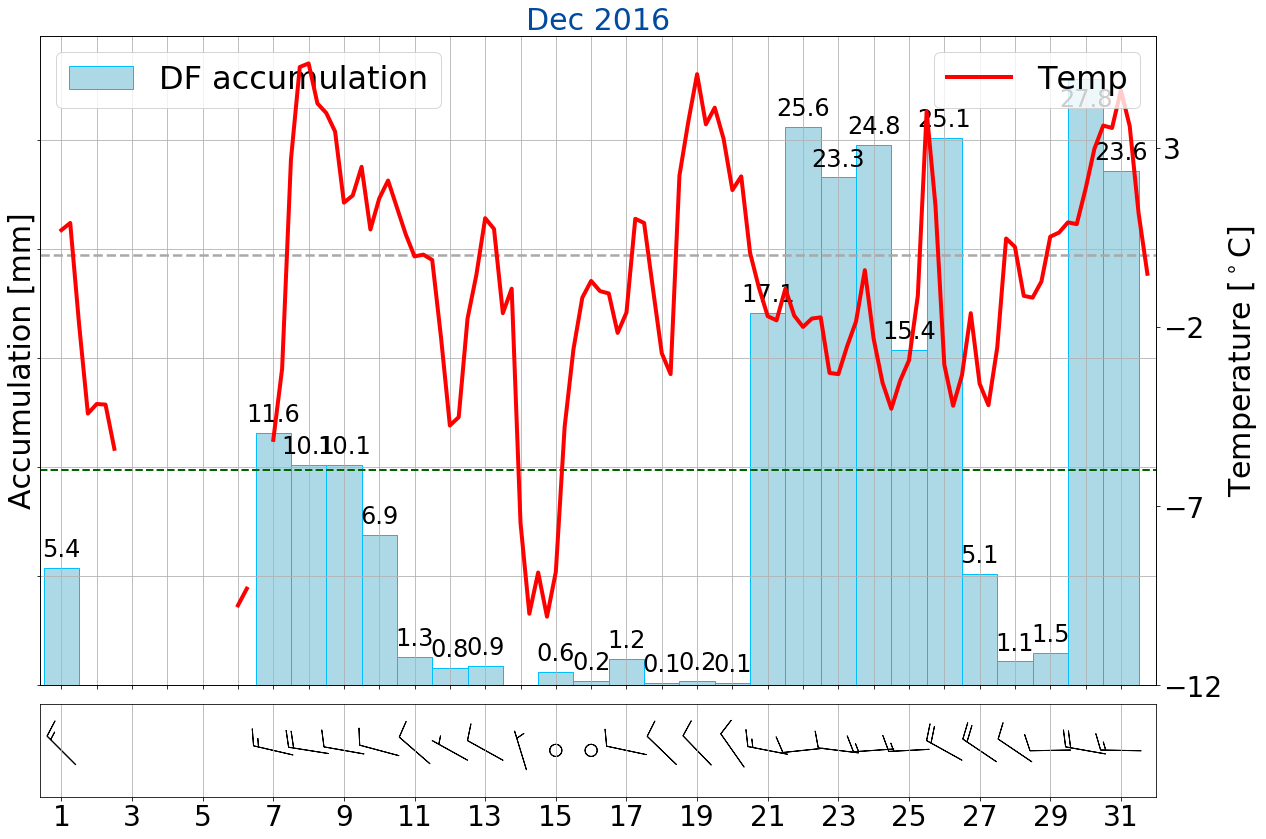

In [51]:
fig = plt.figure(figsize = (20,14))
fs = 30
gs = gridspec.GridSpec(7,1)
ax1 = fig.add_subplot(gs[:6,:])


barfont = fs-6
yfont = fs
tickfont = fs-2
legenfont = fs+2
# Precipitation
la0 = np.where(prec_sum > 0.0)
bar = ax1.bar(d_prec_sum[la0],prec_sum[la0],width = 1,align='center',label = 'DF accumulation', color='lightblue',
              edgecolor ='deepskyblue')
ab.autolabel(bar,ax1,barfont)
ax1.grid()
plt.setp(ax1.get_xticklabels(), visible=False)

# Temperature
ax2 = ax1.twinx()
line = ax2.plot(np.arange(0,Tmean_6h.shape[0])/4, Tmean_6h,color = 'r',label='Temp',linewidth = 4)
#line = ax2.plot(np.arange(0,TA.shape[0])/24, TA,color = 'r',label='Temp',linewidth = 4)


#linemin = ax2.plot(np.arange(0,4*31), Tmin, color = 'b', label = 'Temp$_{min}$', linewidth = 2, linestyle= '--')
#linemax = ax2.plot(np.arange(0,4*31), Tmax, color = 'darkred', label = 'Temp$_{max}$', linewidth = 2, linestyle= '--')
ax2.axhline(y = 0., c ='darkgray', linewidth = 2.5, zorder = 0, linestyle = '--')
ax2.axhline(y = -6., c ='darkgreen', linewidth = 2, zorder = 0, linestyle = '--')

# labeling Precip
ax1.set_ylabel('Accumulation [mm]',fontsize = yfont)
#ax1.set_yticklabels(prec_tick,fontsize = tickfont)
ax1.set_xticks(np.arange(0,31))
ax1.set_xticklabels(np.arange(0,31), fontsize=tickfont)
ax1.set_xlim([-0.6,31.])
ax1.set_ylim([0.,np.nanmax(prec_sum)+2])
ax1.legend(loc='upper left', fontsize=legenfont )
plt.setp(ax1.get_yticklabels(), visible=False)

    # labeling Temp
ax2.set_yticks(T)
ax2.set_ylabel('Temperature [$^\circ$C]',fontsize = yfont)
ax2.tick_params(axis='both', which= 'major', labelsize=tickfont)
ax2.legend(loc='upper right', fontsize = legenfont )

    

# Wind
# share x only
ax3 = plt.subplot(gs[6,:])#, sharex=ax1)

ax3.barbs(np.arange(0,31), np.zeros(np.asarray(day_wind).shape[0]), U, V, length = 9, pivot='middle')
# labeling Wind
ax3.axes.get_yaxis().set_visible(False)
ax3.tick_params(axis='both', which= 'major', labelsize=tickfont)
ax3.set_xticks(np.arange(0,31,2))
ax3.set_xticklabels(np.arange(1,32,2), fontsize=tickfont)
ax3.set_xlim([-0.6,31.])
ax3.set_ylim([-0.001,0.001])
ax3.grid()
        
ax1.set_title('%s %s' %(calmon, (year_precip[0][0])),fontsize=fs, color=blue)
if savefig == 1:
    SF.save_figure_landscape(figdir, fig_name, form )
plt.show()